# Exploratory Data Analysis (EDA)

Step 1: Load the dataset and develop an initial understanding
    - Inspect shape, preview rows, review variable types, isolate the target.

Step 2: Assess missing values and remove variables with excessive missingness
    - Compute missing-value percentages, drop columns based on 30% threshold.

Step 3: Correct variable types and recode categories
    - Convert numerical to categorical where needed, encode ordinal variables, fix dtype inconsistencies.

Step 4: Univariate analysis
    - Inspect skewness, assess rare categories in categorical data (< 1%) and outliers in numerical variables (1.5 * IQR).

Step 5: Bivariate analysis
    - Assess correlation of numeric features with the sale price, calculate spread of categorical features over sale price using eta-squared

Step 6: Multivariate checks and feature interactions

Step 7: Prepare final feature lists for modeling

In [1]:
# Define necessary functions
def encode_ordinal(df, columns, order):
    for column in columns:
        df[column] = (
            pd.Categorical(df[column], categories=order, ordered=True)
            .codes
            .astype('float')
        )
        df[column] = df[column].replace(-1, np.nan)
    return df

def get_n_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((df[column] < lower) | (df[column] > upper)).sum()

def get_eta_squared(df, col, target, target_name):
    groups = df.join(target).groupby(col)[target_name]
    
    # group means
    means = groups.mean()
    # overall mean
    grand_mean = df.join(target)[target_name].mean()
    # group sizes
    ns = groups.count()
    
    # between-group sum of squares
    ss_between = np.sum(ns * (means - grand_mean)**2)
    # total sum of squares
    ss_total = np.sum((df.join(target)[target_name] - grand_mean)**2)
    
    return ss_between / ss_total

In [2]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.api.types as pd_types
from datetime import date
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Print file names in directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Step 1: Load the dataset and develop an initial understanding

In [3]:
# specify input paths
train_file_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
submission_file_path = '/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv'

# load as pandas data frames
df = pd.read_csv(train_file_path)
sub_df = pd.read_csv(submission_file_path)

# separate variables
target = df["SalePrice"]
df = df.drop(columns=["SalePrice", "Id"])

# display options
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

df.head(20)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,...,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,...,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,...,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,...,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,...,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,...,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,...,Typ,2,TA,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

A quick view of the data suggests the following:

(1) Some variables, like 'GarageQual', may be on an ordinal scale but use categories (e.g., TA, Fa, Gd) while other variable denote a class, such as 'MSSubClass', but use integers. This suggests that some variables may need to be recoded

(2) In addition, other variables, like '', show missing data in these first entries. Therefore, variables may need to be dropped from the dataset. I use a threshold of 30% to decide which to exclude.

# Step 2: Assess missing values and remove variables

In [5]:
# calculate percentage of missing values per column
pct_missing = (df.isna().sum() / len(df) * 100).round(2)
drop_vars = pct_missing[pct_missing > 30].index.tolist() # get columns names above threshold

# Show columns with highest amount of missing values
print(pct_missing.sort_values(ascending=False))
print(drop_vars)

# Drop columns with too many missing values from the dataset
df = df.drop(columns=drop_vars)
pct_missing = (df.isna().sum() / len(df) * 100).round(2)

PoolQC           99.52
MiscFeature      96.30
Alley            93.77
Fence            80.75
MasVnrType       59.73
                 ...  
MiscVal           0.00
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
Length: 79, dtype: float64
['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


Missing values for the remaining columns will later be imputed using the most common or median value via scikit-learn pipelines.

# Step 3: Correct variable types and recode categories

In [6]:
# Recode dtype based on variable descriptions #

# Change MSSubClass from numeric to unordered object: 
df['MSSubClass'] = df['MSSubClass'].astype('object')  # or 'object'

# Recode quality ratings from unordered objects to ordered categories:
qual_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
columns = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']
df = encode_ordinal(df, columns, qual_order)

qual_order = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
columns = ['BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond']
df = encode_ordinal(df, columns, qual_order)

qual_order = ['NA', 'No', 'Mn', 'Av', 'Gd']
columns = ['BsmtExposure']
df = encode_ordinal(df, columns, qual_order)

qual_order = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
columns = ['BsmtFinType1', 'BsmtFinType2']
df = encode_ordinal(df, columns, qual_order)

# Convert Year
df['GarageYrBlt'] = df['GarageYrBlt'].astype('float')

df.dtypes.value_counts()

int64      32
object     27
float64    14
Name: count, dtype: int64

These changes target some obvious errors, such as 'MSSubClass' being an integer despite representing unordered categories, as well as categorical variables with unordered variables that should be ordinal.
After recoding the variables, there are 33 (int64) + 14 (float64) numeric and 27 (object) categorical features

# Step 4: Univariate analysis

In [7]:
# Separate data into numeric and categorical features
num_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_vars = df.select_dtypes(include=['object']).columns.tolist()

In [8]:
rare_levels = {} # initialize dictionary

for col in cat_vars: # loop over categorical variables
    freq = df[col].value_counts(normalize=True) # get normalized frequency of category occurrance
    rare = freq[freq < 0.01]  # 1% threshold
    if not rare.empty:
        rare_levels[col] = rare.index.tolist() # add rare categories to dictionary as a list

rare_levels

{'MSSubClass': [45, 180, 40],
 'MSZoning': ['C (all)'],
 'Street': ['Grvl'],
 'LotShape': ['IR3'],
 'Utilities': ['NoSeWa'],
 'LotConfig': ['FR3'],
 'LandSlope': ['Sev'],
 'Neighborhood': ['Veenker', 'NPkVill', 'Blueste'],
 'Condition1': ['RRAe', 'PosA', 'RRNn', 'RRNe'],
 'Condition2': ['Feedr', 'Artery', 'RRNn', 'PosN', 'PosA', 'RRAn', 'RRAe'],
 'HouseStyle': ['1.5Unf', '2.5Unf', '2.5Fin'],
 'RoofStyle': ['Flat', 'Gambrel', 'Mansard', 'Shed'],
 'RoofMatl': ['Tar&Grv',
  'WdShngl',
  'WdShake',
  'Metal',
  'Membran',
  'Roll',
  'ClyTile'],
 'Exterior1st': ['BrkComm', 'Stone', 'AsphShn', 'ImStucc', 'CBlock'],
 'Exterior2nd': ['ImStucc', 'Brk Cmn', 'Stone', 'AsphShn', 'Other', 'CBlock'],
 'Foundation': ['Stone', 'Wood'],
 'Heating': ['Grav', 'Wall', 'OthW', 'Floor'],
 'Electrical': ['FuseP', 'Mix'],
 'Functional': ['Maj1', 'Maj2', 'Sev'],
 'GarageType': ['CarPort', '2Types'],
 'SaleType': ['ConLD', 'ConLI', 'ConLw', 'CWD', 'Oth', 'Con'],
 'SaleCondition': ['Alloca', 'AdjLand']}

Quite a few categorical variables show rare levels (i.e., making up less than 1% of the data). This suggests it may be necessary to collapse rare categories or use methods that are robust to rare categories, such as random tree models.

In [9]:
# Add right- and left-skewed features to list
skewness = df[num_vars].skew().sort_values(ascending=False)
skewed_features = skewness[abs(skewness)>1].index.tolist()
print(skewed_features)
print(len(skewed_features))

['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'BsmtFinType2', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'BsmtFinSF1', 'WoodDeckSF', 'TotalBsmtSF', 'ExterCond', '1stFlrSF', 'GrLivArea', 'BsmtExposure', 'GarageQual', 'GarageCond']
23


Variables with excessive skewness (>1) will later be transformed in the scikit-learn pipeline. Next, let's look at numerical outliers and rare categories.

In [10]:
numeric_outliers = {}

for col in num_vars:
    n_outliers = get_n_outliers(df, col)
    if n_outliers > 0:
        numeric_outliers[col] = n_outliers

print(numeric_outliers)
print(len(numeric_outliers))

{'LotFrontage': np.int64(88), 'LotArea': np.int64(69), 'OverallQual': np.int64(2), 'OverallCond': np.int64(125), 'YearBuilt': np.int64(7), 'MasVnrArea': np.int64(96), 'ExterCond': np.int64(178), 'BsmtCond': np.int64(112), 'BsmtExposure': np.int64(134), 'BsmtFinSF1': np.int64(7), 'BsmtFinType2': np.int64(166), 'BsmtFinSF2': np.int64(167), 'BsmtUnfSF': np.int64(29), 'TotalBsmtSF': np.int64(61), '1stFlrSF': np.int64(20), '2ndFlrSF': np.int64(2), 'LowQualFinSF': np.int64(26), 'GrLivArea': np.int64(31), 'BsmtFullBath': np.int64(1), 'BsmtHalfBath': np.int64(82), 'BedroomAbvGr': np.int64(35), 'KitchenAbvGr': np.int64(68), 'TotRmsAbvGrd': np.int64(30), 'Fireplaces': np.int64(5), 'GarageCars': np.int64(5), 'GarageArea': np.int64(21), 'GarageQual': np.int64(68), 'GarageCond': np.int64(53), 'WoodDeckSF': np.int64(32), 'OpenPorchSF': np.int64(77), 'EnclosedPorch': np.int64(208), '3SsnPorch': np.int64(24), 'ScreenPorch': np.int64(116), 'PoolArea': np.int64(7), 'MiscVal': np.int64(52)}
35


Several numerical variables contain a 100-200 observations outside the 1.5×IQR bounds. These skewed features will need to be transformed later on.


In [11]:
# sanity check: any negative values?
invalid_negative = {}

for col in num_vars:
    if (df[col] < 0).any():
        invalid_negative[col] = df[df[col] < 0][col].values

invalid_negative

{}

In [12]:
# sanity_check: any wrong years
invalid_years = {}

year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
current_year = date.today()
current_year = current_year.year

for col in year_features:
    if (df[col]> current_year).any():
        invalid_years[col] = df[df[col] > current_year][col].values

invalid_years

{}

No negative values or invalid years are in the dataset, so no corrections are necessary here.

In [13]:
#save information in a summary dictionary
eda_summary = {
    "skewed_features": skewed_features,
    "columns_with_rare_levels": rare_levels,
    "columns_with_outliers": numeric_outliers
}

# Step 5: Bivariate analysis

In [14]:
# assess correlation between all numerical columns and the dependent variable.
num_corr = df[num_vars].join(target).corr()['SalePrice'].sort_values(ascending=False)
num_corr.drop('SalePrice')

OverallQual      0.790982
GrLivArea        0.708624
ExterQual        0.682639
KitchenQual      0.659600
BsmtQual         0.644019
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
HeatingQC        0.427649
BsmtFinSF1       0.386420
BsmtExposure     0.352958
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
BsmtFinType1     0.277436
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
BsmtCond         0.160658
GarageQual       0.156693
GarageCond       0.125013
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
ExterCond        0.018899
BsmtFinSF2      -0.011378
BsmtHalfBath

The top five numerical predictors are 'OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', and 'BsmtQual'. Predictors with absolute correlations < 0.1 may be removed later on.

In [15]:
cat_eta = {}

for col in cat_vars: # loop over categorical variables
    cat_eta[col] = get_eta_squared(df, col, target, 'SalePrice')

cat_eta = pd.Series(cat_eta, name="eta_squared").sort_values(ascending=False)
cat_eta

Neighborhood     0.545575
Foundation       0.256368
GarageFinish     0.252896
MSSubClass       0.246316
GarageType       0.196227
Exterior2nd      0.153830
Exterior1st      0.152773
SaleType         0.137287
SaleCondition    0.135497
MSZoning         0.107560
HouseStyle       0.086313
LotShape         0.076376
CentralAir       0.063166
Electrical       0.059672
RoofStyle        0.057697
PavedDrive       0.054540
BldgType         0.034534
Condition1       0.032631
RoofMatl         0.031413
LandContour      0.025794
LotConfig        0.021019
Functional       0.016480
Heating          0.014437
Condition2       0.009899
LandSlope        0.002682
Street           0.001684
Utilities        0.000205
Name: eta_squared, dtype: float64

The top 5 categorical variables are 'Neighborhood', 'Foundation', 'GarageFinish', 'GarageType' and 'Exterior2nd'. Predictors like 'Street' and 'Utilities' seem to contain factor levels with minimal spread over the sale price.

# Step 6: Multivariate analysis

<Axes: >

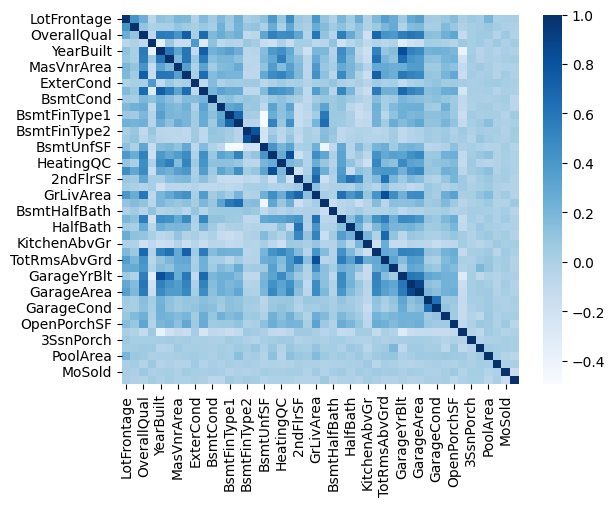

In [17]:
# Calculate correlation between numeric predictors
corr_mat = df[num_vars].corr()
sns.heatmap(corr_mat, cmap="Blues", annot=False)

In [30]:
# get paired correlation 
corr_pairs = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool)) # index the upper triangle of the correlation matrix
corr_pairs = corr_pairs.stack().sort_values(ascending=False) # Stack into series and sort
high_corr_pairs = corr_pairs[corr_pairs>0.8] # use a threshold of 0.8
high_corr_pairs

GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
BsmtFinType2  BsmtFinSF2      0.805212
dtype: float64

Given the number of numeric predictors, only a few pairs show a high correlation (>0.8). One of the predictors in each pair may be dropped later due to redundancy. Let's run PCA next to check whether our dataset is as high-dimensional as the correlation matrix suggests.

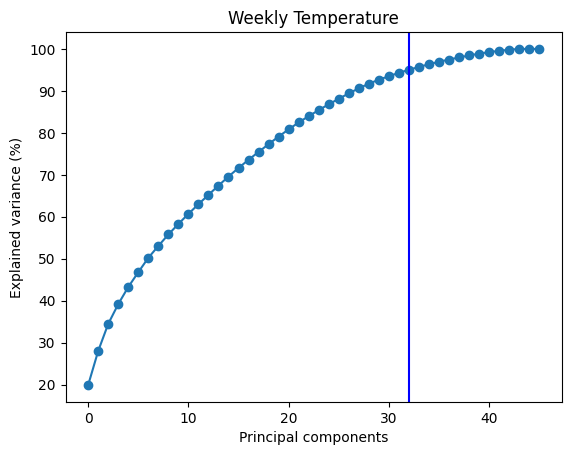

In [62]:
# compute PCA
df_imputed = StandardScaler().fit_transform(df[num_vars].fillna(df[num_vars].median())) #fill missing values first
pca = PCA().fit(df_imputed) # fit PCA
explained = pca.explained_variance_ratio_
exp_cumsum = np.cumsum(explained)*100 # take the cumulative sum of explained variance with each component
exp_range = range(len(np.cumsum(explained)))
above_95 = np.nonzero(exp_cumsum>95)[0][0] # find te index at which explained variance exceeds 95%

# plot the results
plt.plot(exp_range, exp_cumsum, marker='o')
plt.title('Weekly Temperature')
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
plt.axvline(x = above_95, color = 'b', label = '95% threshold')
plt.show()

32 components are necessary to explain 95% of the variance in the numeric predictors. This suggests the dataset is moderately high-dimensional. No drastic dimensionality reduction seems necessary at this point.